In [1]:
# Our custom module
from nn import DeepQNetwork
from custom_parking_env import ParkingWithObstacles
from relay_mem import ReplayMemory,Transition

# python module
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from IPython import display

# combine observation
def process_observation(observation):
    # observation_vector = np.concatenate((
    #     observation["observation"],
    #     observation["achieved_goal"],
    #     observation["desired_goal"]
    # ))
    return observation["observation"]

# interactive mode
plt.ion()

# Create the original environment and wrap it into an environment with obstacles
env_origin = gym.make("parking-v0")#,render_mode="human")
env = ParkingWithObstacles(env_origin)
env.define_spaces()

# terminated The episode is over if the ego vehicle crashed or the goal is reached or time is over.
terminated = False

# The episode is truncated if the time is over.
truncated = False

# Print the number of states and actions
print(f"Observation Space: {env.observation_space}")
# observation["observation"] Box(-inf, inf, (6,), float64)
# observation["achieved_goal"] Box(-inf, inf, (6,), float64)
# observation["desired_goal"] Box(-inf, inf, (6,), float64)

print(f"Action Space: {env.action_space}")
# Discrete(5)


# Get the number of state observations
state, info = env.reset()



Observation Space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))
Action Space: Box(-1.0, 1.0, (2,), float32)


In [2]:
# if GPU is to be used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
candidate_actions = []

for steering in np.linspace(-0.5, 0.5, 4):
        for acceleration in np.linspace(0.8, 0.4, 11):
            candidate_actions.append(torch.tensor([acceleration, steering],device=torch.device("cpu")))
            
# print(candidate_actions)

# Get number of actions from gym action space
n_actions = len(candidate_actions)
n_observations = len(process_observation(state))  # 6 (observation)

Using CPU


In [3]:


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
TARGET_UPDATE = 10
LR = 0.0001
EPISODES = 300

policy_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net = DeepQNetwork(n_observations, n_actions).to(device)
# init weight (by policy net)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(20000)

# Training loop
num_episodes = EPISODES
epsilon_decay_rate = -np.log(EPS_END / EPS_START) / num_episodes
epsilon_values = []
episode_rewards = []  # Store total rewards per episode
losses = []
episode_durations = []

In [4]:
steps_done = 0
def select_action(state , i_episode):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPS_START * np.exp(-epsilon_decay_rate * i_episode)
    epsilon_values.append(epsilon_threshold)
    steps_done += 1
    # exploitation
    if sample > epsilon_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # tensor 1x1 , return action index
            return policy_net(state).max(1).indices.view(1, 1)
    # exploration
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_policy_net():
    # Check if enough transitions are available in replay_buffer
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
                        tuple(map(lambda s: s is not None,
                        batch.next_state)), 
                        device=device, 
                        dtype=torch.bool)
    
    non_final_next_states = []
    for s in batch.next_state:
        if s is not None:  # Check if s is not None
            non_final_next_states.append(s)  # Add elements that meet the condition to the list
    
    if len(non_final_next_states) == 0 :
        # Use a placeholder tensor with the appropriate shape
        # Assuming the state has a known shape, e.g., (batch_size, state_dim)
        non_final_next_states = tuple(torch.zeros(torch.Size([1, 6]), device=device).unsqueeze(0))
        print("none occur")

    # RuntimeError: torch.cat(): expected a non-empty list of Tensors
    non_final_next_states = torch.cat(non_final_next_states)
    
    # Concatenate batch tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the policy network
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    optimizer.step()

    # Track the loss for plotting
    losses.append(loss.item())
    print(f"Loss: {loss.item()}")

def moving_average(data, window_size=50):
    # convolution
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_durations():
    # Create a new figure for the plot
    plt.clf()

    # Convert episode rewards to tensors
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float, device=device)

    # Plot rewards per episode
    plt.subplot(3, 1, 1)
    plt.title('Training Progress (Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Move GPU tensor back to CPU and convert it to NumPy
    plt.plot(rewards_t.cpu().numpy(), label="Total Reward")
    
    # Add smoothed rewards
    if len(episode_rewards) >= 50:  # Ensure enough data for smoothing
        smoothed_rewards = moving_average(episode_rewards, window_size=50)
        plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards", color='orange')
    plt.legend()

    # Plot losses per step
    plt.subplot(3, 1, 2)
    plt.title('Loss (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.plot(losses, label="Loss", color='red')
    plt.legend()

    # Plot epsilon decay per step
    plt.subplot(3, 1, 3)
    plt.title('Epsilon Decay (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
    plt.legend()

    # Adjust layout to increase space between plots
    plt.subplots_adjust(hspace=0.5)  # Adjust spacing between rows

    # Pause briefly to update the plot
    plt.pause(0.01)

    # Clear the current output and display the updated plot
    display.display(plt.gcf())

Loss: 0.11650448057819521
Loss: 8.514591846753127
Loss: 0.08161430724012497
Loss: 0.20908498394786562
Loss: 0.05841306319980902
Loss: 0.04518178511971552
Loss: 0.028846759833076413
Loss: 0.05442255727389985
Loss: 0.11455235750756308
Loss: 0.0722642264704017
Loss: 0.03813705973613324
Loss: 0.018199229235648748
Loss: 0.039353793843579225
Loss: 0.025069809076264916
Loss: 0.041107995240696395
Loss: 0.013681701492323953
Loss: 0.012106609184573718
Loss: 0.010181059854752319
Loss: 0.020344331636159528
Loss: 0.013923593201410584
Loss: 0.020002820969095298
Loss: 0.007445431795337612
Loss: 0.006993499405319447
Loss: 0.006298883750531109
Loss: 0.008615473381117745
Loss: 0.00657825732536711
Loss: 0.009563874264352928
Loss: 0.005784503991868776
Loss: 0.006829079574868401
Loss: 0.004341017749404078
Loss: 0.0072666194423251325
Loss: 0.005089941753684214
Loss: 0.004561350605524269
Loss: 0.0030067835101186885
Loss: 0.004784948189189176
Loss: 0.004749646574592368
Loss: 0.005234366659066887
Loss: 0.00286

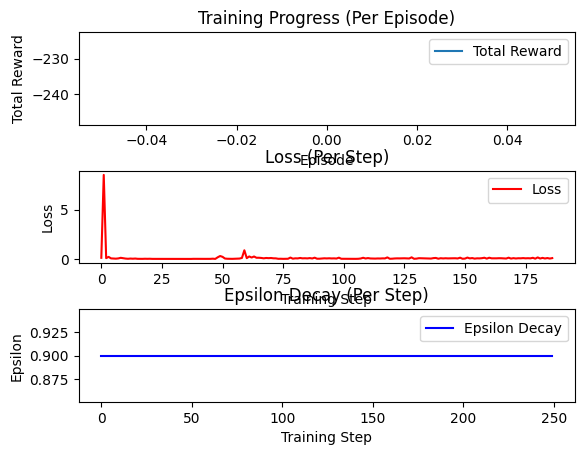

<Figure size 640x480 with 0 Axes>

Episode 1/300, Total Reward: -235.54848673444766
Loss: 0.0523778959544804
Loss: 0.10607207364632464
Loss: 0.025972069148482026
Loss: 0.0815817305302179
Loss: 0.059782214462079875
Loss: 0.05986149494475161
Loss: 0.0594761037819247
Loss: 0.07025022440950751
Loss: 0.06254824708415402
Loss: 0.058503727743941344
Loss: 0.0529433456763016
Loss: 0.15120920735710397
Loss: 0.030418325716944444
Loss: 0.07885129126741466
Loss: 0.13054684769604966
Loss: 0.08266687143766244
Loss: 0.07433112926039614
Loss: 0.07149792800138334
Loss: 0.07165383687575277
Loss: 0.060544246282882415
Loss: 0.06068180594990329
Loss: 0.16282786175863426
Loss: 0.058062805523061894
Loss: 0.11139010054639445
Loss: 0.0400145437460692
Loss: 0.10504053603997861
Loss: 0.039436629840074386
Loss: 0.09478579655593633
Loss: 0.09207079962870353
Loss: 0.08756793954976304
Loss: 0.11304971823837408
Loss: 0.04494532522461906
Loss: 0.08574645001277023
Loss: 0.04981225727505618
Loss: 0.08579576641117516
Loss: 0.06671508352161636
Loss: 0.04720

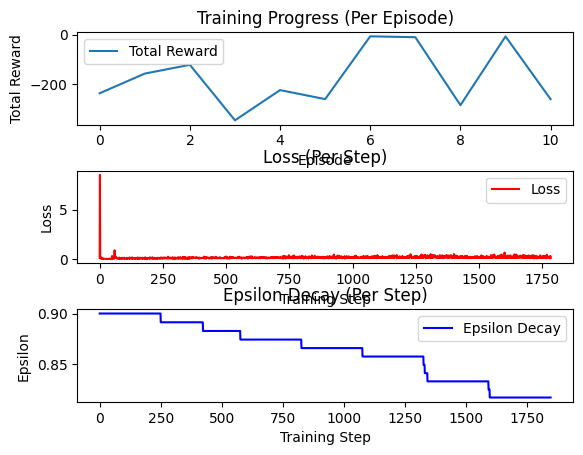

<Figure size 640x480 with 0 Axes>

Episode 11/300, Total Reward: -259.5016628137656
Loss: 0.2019970498296088
Loss: 0.11155501848118614
Loss: 0.14666385814477587
Loss: 0.20361783491829194
Loss: 0.14049725663235743
Loss: 0.11620139636944452
Loss: 0.29521447824878594
Loss: 0.34351798184891574
Loss: 0.1332520071700674
Loss: 0.1316094211680196
Loss: 0.12412467650844197
Loss: 0.20001261995876274
Loss: 0.05065726877125464
Loss: 0.1690060310530602
Loss: 0.06678147046778544
Loss: 0.21063153812376514
Loss: 0.09969926872212082
Loss: 0.17334286186451367
Loss: 0.0906315259775953
Loss: 0.11642974133947566
Loss: 0.11555385775334644
Loss: 0.07197293318956786
Loss: 0.17431190434341495
Loss: 0.08579149444789742
Loss: 0.1861761070340459
Loss: 0.11128379302496458
Loss: 0.21953588525830067
Loss: 0.18152663972419805
Loss: 0.23495826681695098
Loss: 0.07461280138855744
Loss: 0.4288370357429862
Loss: 0.0799985352016248
Loss: 0.29473559015100836
Loss: 0.10291387028850163
Loss: 0.1277013926221533
Loss: 0.10248186772492197
Loss: 0.1544008193540725

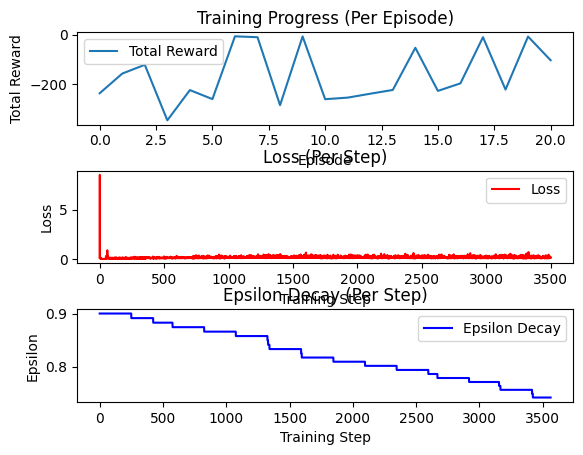

<Figure size 640x480 with 0 Axes>

Episode 21/300, Total Reward: -102.80167244608337
Loss: 0.08695302859467798
Loss: 0.10465961139069391
Loss: 0.14092794695304117
Loss: 0.08594225668660208
Loss: 0.27747902963816407
Loss: 0.08735590558024361
Loss: 0.11269358719084038
Loss: 0.0811693935056122
Loss: 0.08765501707799471
Loss: 0.2404584031888057
Loss: 0.12261308279716993
Loss: 0.09860505767418805
Loss: 0.18208387030501624
Loss: 0.1324041186710587
Loss: 0.14275904623512542
Loss: 0.10623941073631525
Loss: 0.13267993634373054
Loss: 0.08134657477847851
Loss: 0.20999283104896044
Loss: 0.06201627080344323
Loss: 0.20893785198300166
Loss: 0.07396098548050775
Loss: 0.21055128966555037
Loss: 0.2886780089130188
Loss: 0.20809619380362515
Loss: 0.08501626667594325
Loss: 0.21274005988708036
Loss: 0.10461051393750245
Loss: 0.12583957119708253
Loss: 0.08734956546502987
Loss: 0.17675479910080788
Loss: 0.08222275378955177
Loss: 0.19222326163478318
Loss: 0.10572101929376986
Loss: 0.13531304776098294
Loss: 0.10081635860719822
Loss: 0.1201656172

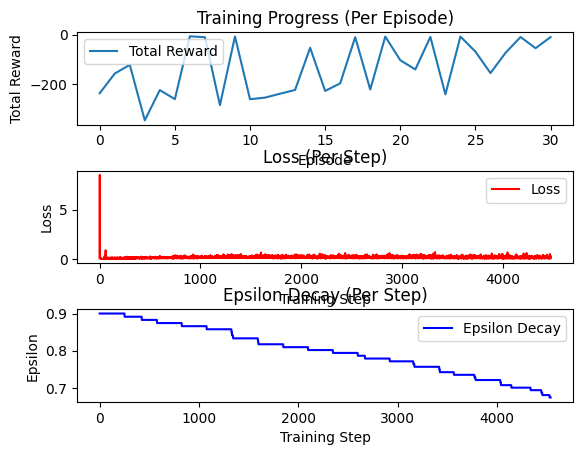

<Figure size 640x480 with 0 Axes>

Episode 31/300, Total Reward: -9.541242649644204
Loss: 0.330399668385104
Loss: 0.12009749210970001
Loss: 0.24136776051893888
Loss: 0.10079489628131295
Loss: 0.15249161428846134
Loss: 0.10583311936906131
Loss: 0.12277873781928852
Loss: 0.110801790257618
Loss: 0.09745590782514481
Loss: 0.11683095995712182
Loss: 0.16825477880097003
Loss: 0.345702769666249
Loss: 0.46468184995454387
Loss: 0.1530222354260634
Loss: 0.15280078488358448
Loss: 0.23238526762396272
Loss: 0.15387498956290319
Loss: 0.07525857833753552
Loss: 0.16280656641517416
Loss: 0.1107224534162986
Loss: 0.2916088560511629
Loss: 0.07074538325458932
Loss: 0.19858619013678025
Loss: 0.10391433633498418
Loss: 0.14861253491065868
Loss: 0.12435458832321909
Loss: 0.15910299684652085
Loss: 0.06318813272145188
Loss: 0.09776640749583801
Loss: 0.07950298623452769
Loss: 0.13329858840671577
Loss: 0.05767567293441303
Loss: 0.13172930100971442
Loss: 0.1477221604235281
Loss: 0.160213997898357
Loss: 0.1519928019279418
Loss: 0.1744066146011304
Los

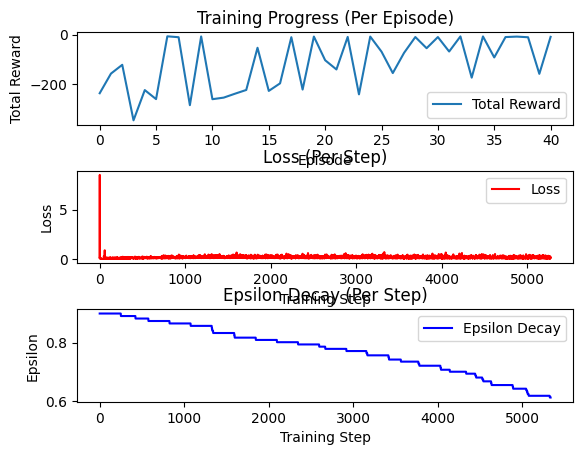

<Figure size 640x480 with 0 Axes>

Episode 41/300, Total Reward: -8.732145749120791
Loss: 0.054740761688425406
Loss: 0.23674834121371582
Loss: 0.3983941533402806
Loss: 0.09596631091810987
Loss: 0.06764095195238241
Done: True, Truncated: False
{'speed': 3.080000000000001, 'crashed': True, 'action': array([0.4       , 0.16666667]), 'is_success': False}
Episode 42/300, Total Reward: -7.495232187551568
Loss: 0.10458394738897149
Loss: 0.1559825571027683
Loss: 0.25804123780862886
Loss: 0.2215713006423986
Loss: 0.17411053370893687
Loss: 0.08745370254762702
Loss: 0.2399662731600769
Loss: 0.060569096130410865
Loss: 0.2568017367378451
Loss: 0.0748169528407488
Loss: 0.1964244359439253
Done: True, Truncated: False
{'speed': 5.888711111111112, 'crashed': True, 'action': array([0.72, 0.5 ]), 'is_success': False}
Episode 43/300, Total Reward: -10.059007580587858
Loss: 0.04836068077918952
Loss: 0.194389818769935
Loss: 0.16358350032025068
Loss: 0.10715406976800672
Loss: 0.24341597121776565
Loss: 0.11617629563731433
Loss: 0.0947026508021

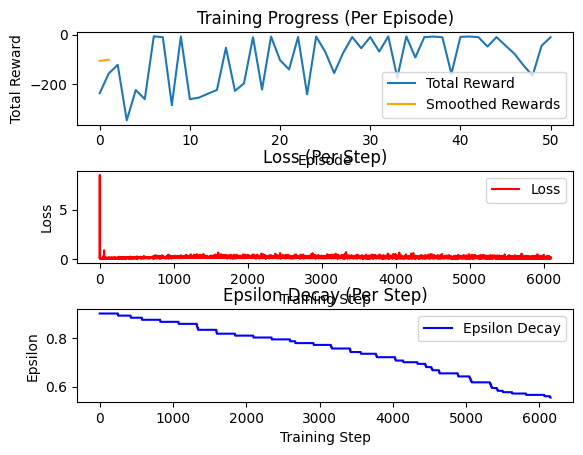

<Figure size 640x480 with 0 Axes>

Episode 51/300, Total Reward: -10.200360685219561
Loss: 0.19271093320918087
Loss: 0.13695730335640896
Loss: 0.3566093886074406
Loss: 0.09109329003775471
Loss: 0.1347378750807662
Done: True, Truncated: False
{'speed': 3.120000000000001, 'crashed': True, 'action': array([ 0.48, -0.5 ]), 'is_success': False}
Episode 52/300, Total Reward: -7.108732756528231
Loss: 0.07405185815595328
Loss: 0.10224728078123174
Loss: 0.309821246307851
Loss: 0.08967021108564699
Loss: 0.07461319206405842
Loss: 0.11040439431221342
Loss: 0.07230692142422752
Loss: 0.09454717960155101
Loss: 0.21622782298135107
Loss: 0.09691818570098429
Loss: 0.06710183956286785
Loss: 0.2478605586121654
Loss: 0.08493165860821324
Loss: 0.27813408788860566
Loss: 0.0701402147842074
Loss: 0.1610893094280402
Loss: 0.06712495764390869
Loss: 0.052550056637488546
Loss: 0.23292595599824792
Loss: 0.08439155997583295
Loss: 0.05508767759338765
Loss: 0.0694374639801624
Loss: 0.1944690697160113
Loss: 0.08783314582267071
Loss: 0.08674994936537095


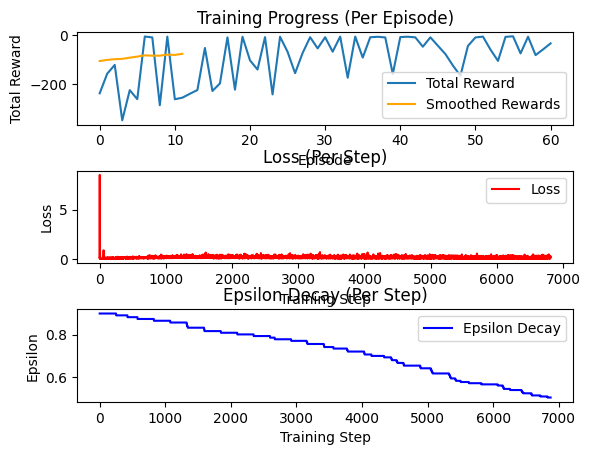

<Figure size 640x480 with 0 Axes>

Episode 61/300, Total Reward: -34.34246171683746
Loss: 0.17962012312904346
Loss: 0.06671805108605607
Loss: 0.3339598119574491
Loss: 0.2546732197659102
Loss: 0.09008389879222761
Loss: 0.04250895868016484
Done: True, Truncated: False
{'speed': 2.46234074074074, 'crashed': True, 'action': array([ 0.68, -0.5 ]), 'is_success': False}
Episode 62/300, Total Reward: -7.076841126372241
Loss: 0.0994978235124638
Loss: 0.04268271249961217
Loss: 0.15666895858275082
Loss: 0.27274087354426146
Loss: 0.12422336553825329
Loss: 0.08999082584476589
Loss: 0.07049592206277874
Loss: 0.06442518832556651
Loss: 0.1479233698315413
Loss: 0.057944668326607114
Loss: 0.10357278682679694
Loss: 0.05461921510142985
Loss: 0.11130097799208553
Loss: 0.1699398129618635
Loss: 0.44244372652577313
Loss: 0.17121104023070743
Loss: 0.07412534773052584
Loss: 0.11190563326763481
Loss: 0.08746623466206147
Loss: 0.34367937118131375
Loss: 0.08550874351204668
Loss: 0.08028111348011324
Loss: 0.10585649363101467
Loss: 0.1220819143514024

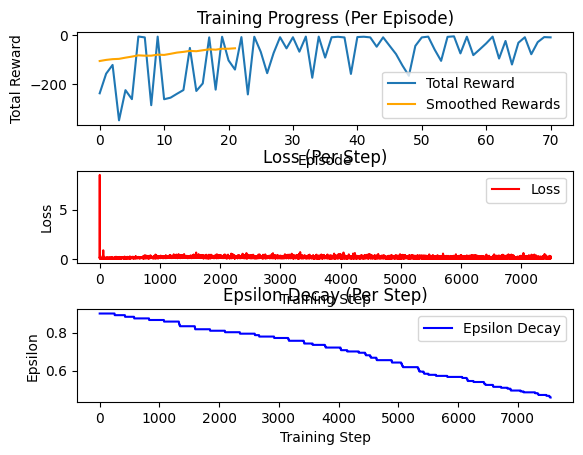

<Figure size 640x480 with 0 Axes>

Episode 71/300, Total Reward: -10.025854043479889
Loss: 0.08286821424068341
Loss: 0.2111592067064324
Loss: 0.20819814237531184
Loss: 0.0800637373742391
Loss: 0.10750382695866918
Loss: 0.5393565218608755
Loss: 0.1328113701312007
Loss: 0.07589786169716892
Loss: 0.1575240905702769
Loss: 0.1648066956422934
Loss: 0.1574998694507319
Loss: 0.06728589951493316
Loss: 0.12364016349011446
Loss: 0.09539876288622667
Loss: 0.07193546797535359
Loss: 0.21080739492711936
Loss: 0.04613509351353022
Loss: 0.0734571005506032
Loss: 0.056735697012970675
Loss: 0.05391185079617896
Loss: 0.2498558208376336
Loss: 0.04147038637541112
Loss: 0.09098793123944024
Loss: 0.06175317234667506
Loss: 0.17141030491399858
Loss: 0.0743616081817893
Loss: 0.08660429787060125
Loss: 0.052741814265295686
Loss: 0.07836241725996755
Loss: 0.16872872491688334
Loss: 0.09900937025068857
Loss: 0.10289939079780143
Loss: 0.08727492416526389
Loss: 0.07060944884008918
Loss: 0.5401678607131899
Loss: 0.1217146242269491
Loss: 0.1259079697988797

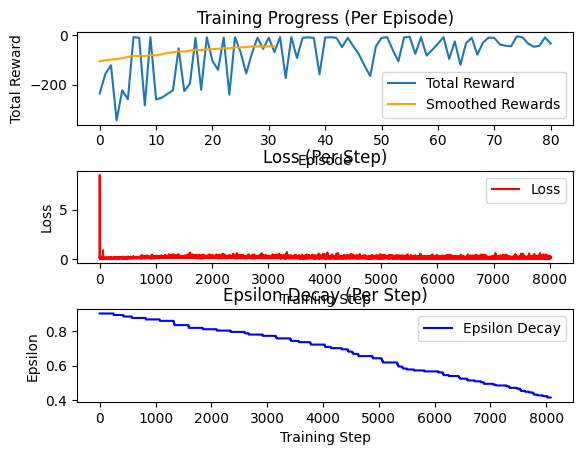

<Figure size 640x480 with 0 Axes>

Episode 81/300, Total Reward: -33.29831224783981
Loss: 0.07517748255352476
Loss: 0.048238209941525806
Loss: 0.3628369307058249
Loss: 0.06859460812213256
Loss: 0.09576426101668978
Loss: 0.0869898589373323
Loss: 0.257787683937854
Loss: 0.20745697664081156
Loss: 0.057607019041785466
Loss: 0.13002191992912782
Loss: 0.09734955999726748
Loss: 0.037509644454024216
Loss: 0.11092750799101014
Loss: 0.04987963739313709
Loss: 0.06110367734224928
Loss: 0.04337116190355495
Loss: 0.06722637367210475
Loss: 0.04181007982722184
Loss: 0.08618503050165117
Loss: 0.04680893184775503
Loss: 0.12292581126644678
Loss: 0.12016071882482851
Loss: 0.059822042408972834
Loss: 0.060072003334017895
Loss: 0.09163607892738475
Loss: 0.09500223603162826
Loss: 0.13051733439885832
Loss: 0.07927446020370633
Loss: 0.10025342686326331
Loss: 0.12451237885670748
Loss: 0.043783896548907145
Loss: 0.07294684534104506
Loss: 0.061704517193166594
Loss: 0.057042202490869984
Loss: 0.12607443917939698
Loss: 0.10627723375693462
Loss: 0.079

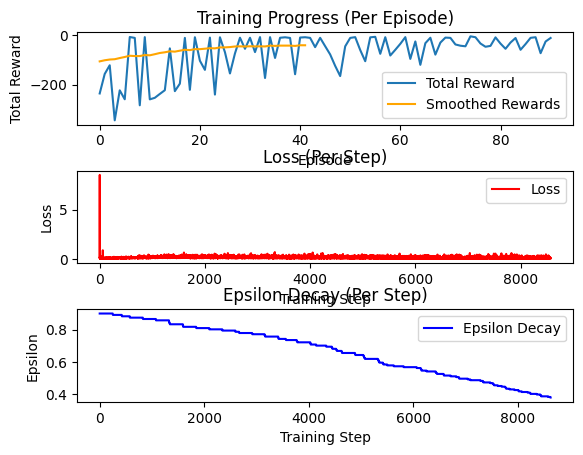

<Figure size 640x480 with 0 Axes>

Episode 91/300, Total Reward: -10.471039851755314
Loss: 0.1529968641012931
Loss: 0.21495243344006365
Loss: 0.08543011260407951
Loss: 0.08361938602566676
Loss: 0.09297140595634466
Loss: 0.20512696837643102
Loss: 0.0949341431343024
Loss: 0.09175340261329093
Loss: 0.0962051846798482
Loss: 0.051305060432206534
Loss: 0.10518371698894066
Done: True, Truncated: False
{'speed': 5.6995555555555555, 'crashed': True, 'action': array([ 0.4, -0.5]), 'is_success': False}
Episode 92/300, Total Reward: -9.984197445738138
Loss: 0.055415482856625634
Loss: 0.04008700756326096
Loss: 0.10164083787019791
Loss: 0.10860603644567474
Loss: 0.14948953864409026
Loss: 0.08981357262097597
Loss: 0.13759994541984572
Loss: 0.17068446519094477
Loss: 0.11043193397444856
Loss: 0.12869339484382106
Loss: 0.059259108300696625
Loss: 0.09532455326772078
Done: True, Truncated: False
{'speed': 5.811555555555558, 'crashed': True, 'action': array([ 0.4, -0.5]), 'is_success': False}
Episode 93/300, Total Reward: -10.03032877624037

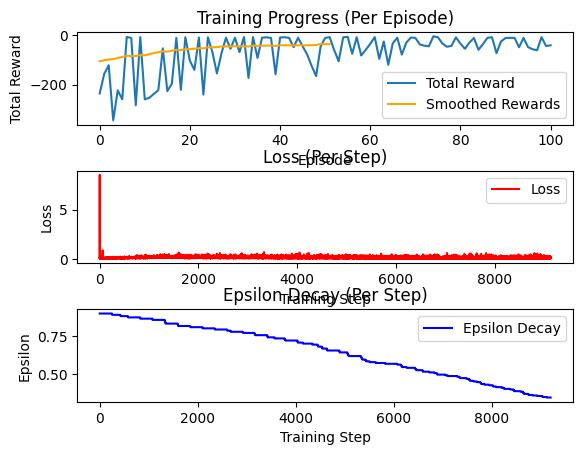

<Figure size 640x480 with 0 Axes>

Episode 101/300, Total Reward: -40.12914393707838
Loss: 0.13878671383085942
Loss: 0.0700376432682457
Loss: 0.08321025216814094
Loss: 0.08067827383411963
Loss: 0.20214090772520654
Loss: 0.08048869478790982
Loss: 0.3151730837242533
Loss: 0.060246198401826934
Loss: 0.07669240380330326
Loss: 0.08770916010632696
Loss: 0.3543531207645141
Loss: 0.16032998695984024
Loss: 0.10226484168973765
Loss: 0.04092890318773728
Loss: 0.23740443798464717
Loss: 0.05422530973769975
Loss: 0.13803502367360448
Loss: 0.04622799057974988
Loss: 0.12315726851853
Loss: 0.04212150849198729
Loss: 0.14448547051695507
Loss: 0.07020213963065004
Loss: 0.08485112328035863
Loss: 0.06682102080617879
Loss: 0.19868150359758602
Loss: 0.0663484880665394
Loss: 0.2930299150013731
Loss: 0.11863974984838707
Loss: 0.06200585578206457
Loss: 0.17865538724810953
Loss: 0.05354933179395441
Loss: 0.036900964880591
Loss: 0.13894853941093593
Loss: 0.056876149870598525
Loss: 0.05892411469745586
Loss: 0.049664776561473535
Loss: 0.0789741891182

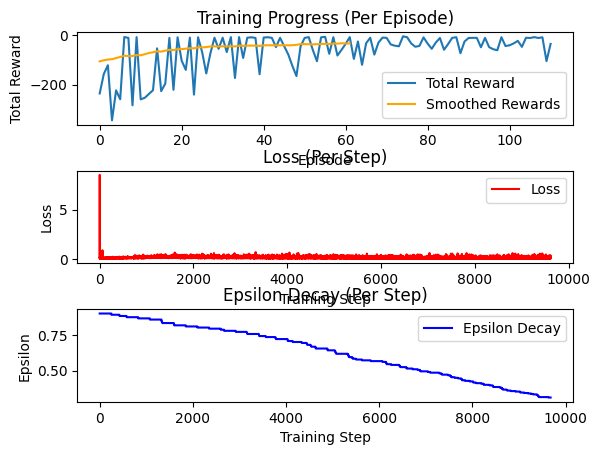

<Figure size 640x480 with 0 Axes>

Episode 111/300, Total Reward: -34.38985253775812
Loss: 0.3459247771793655
Loss: 0.10789737852261788
Loss: 0.19245083058395818
Loss: 0.04430119583407162
Loss: 0.06481091703950903
Loss: 0.055156857134636125
Loss: 0.05410095979612622
Loss: 0.17580425747970052
Loss: 0.12493321347228437
Loss: 0.11225023790690913
Loss: 0.06866331087155947
Loss: 0.03513566844095586
Loss: 0.22963216478049184
Loss: 0.12939297813379072
Loss: 0.10401634864643863
Loss: 0.08073517566581506
Loss: 0.1279086466371972
Loss: 0.061143439771618666
Loss: 0.08888816861138252
Loss: 0.1801514708587482
Loss: 0.14926487519587972
Loss: 0.05087565434076604
Loss: 0.1651268261543668
Loss: 0.09133544736419637
Loss: 0.11667677778534306
Loss: 0.14561458002333158
Loss: 0.0781379184853387
Loss: 0.3698530353744398
Loss: 0.16365078390444018
Loss: 0.07296842923025498
Loss: 0.2645494426890951
Loss: 0.1838955070756937
Loss: 0.08750042146731665
Loss: 0.06366195232262487
Loss: 0.1257977740736328
Loss: 0.0905549333199199
Loss: 0.07442218837690

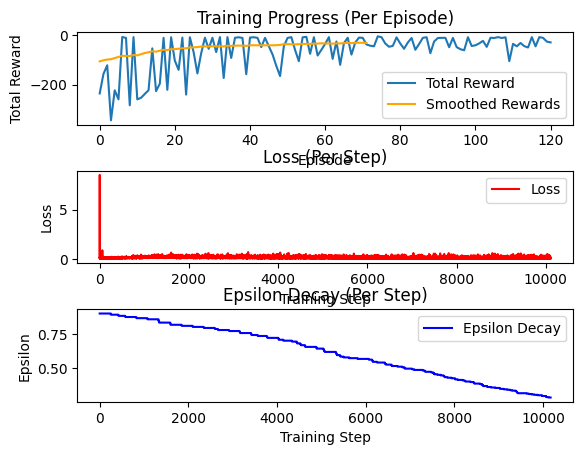

<Figure size 640x480 with 0 Axes>

Episode 121/300, Total Reward: -28.414133291716173
Loss: 0.05968969408532314
Loss: 0.24023197113178196
Loss: 0.19443355434194162
Loss: 0.21572821225237873
Loss: 0.33243809097014687
Loss: 0.09852234382717372
Loss: 0.13021832968185265
Loss: 0.03742723376548775
Loss: 0.10791716031816444
Loss: 0.20439718606906196
Loss: 0.11180916468580807
Done: True, Truncated: False
{'speed': 6.023111111111111, 'crashed': True, 'action': array([0.56, 0.5 ]), 'is_success': False}
Episode 122/300, Total Reward: -9.501617569139977
Loss: 0.03525747257162236
Loss: 0.06541148397097689
Loss: 0.16221463774082634
Loss: 0.10009852926299666
Loss: 0.06338031026687319
Loss: 0.23049553200393602
Loss: 0.30256174895383897
Loss: 0.11342376530780736
Loss: 0.1039951312037621
Loss: 0.3019159973004165
Loss: 0.18553365980629302
Loss: 0.19425514468153998
Loss: 0.23872058470303192
Loss: 0.1347956254537713
Loss: 0.03936468767447056
Loss: 0.02873568448953636
Loss: 0.04300551399646274
Loss: 0.12230282511249163
Loss: 0.0625539232424

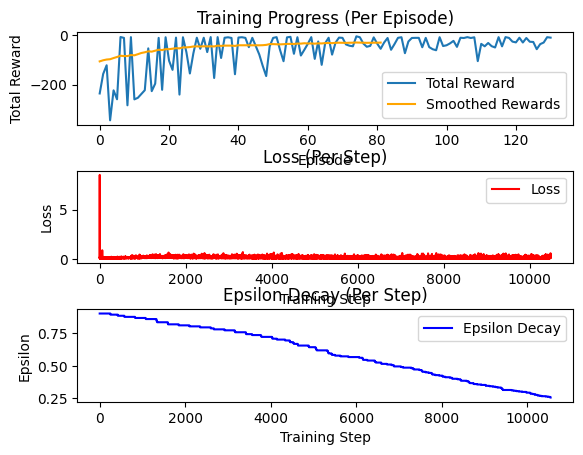

<Figure size 640x480 with 0 Axes>

Episode 131/300, Total Reward: -9.113989729337678
Loss: 0.05219703729179315
Loss: 0.31245055081096734
Loss: 0.09690142718219998
Loss: 0.12314097564133455
Loss: 0.15947790211894367
Loss: 0.11757177703861907
Loss: 0.18596667645689902
Loss: 0.1412770323349012
Loss: 0.04450636846432624
Loss: 0.15217640515465913
Loss: 0.12020908222722573
Done: True, Truncated: False
{'speed': 6.197333333333332, 'crashed': True, 'action': array([ 0.6, -0.5]), 'is_success': False}
Episode 132/300, Total Reward: -10.604882944915737
Loss: 0.26335190814120346
Loss: 0.05956937017904412
Loss: 0.21959461326418117
Loss: 0.10062045338446253
Loss: 0.046348958665901684
Loss: 0.2895070862268393
Loss: 0.13716067140524094
Loss: 0.07337788176302054
Loss: 0.3024860262955465
Loss: 0.09311640057960849
Loss: 0.21927807620042816
Loss: 0.14017370823342742
Loss: 0.20445641206202095
Loss: 0.14430735981190718
Loss: 0.13865176660636383
Loss: 0.11318277367755353
Loss: 0.16703096743811502
Loss: 0.10037331862628363
Loss: 0.049613985381

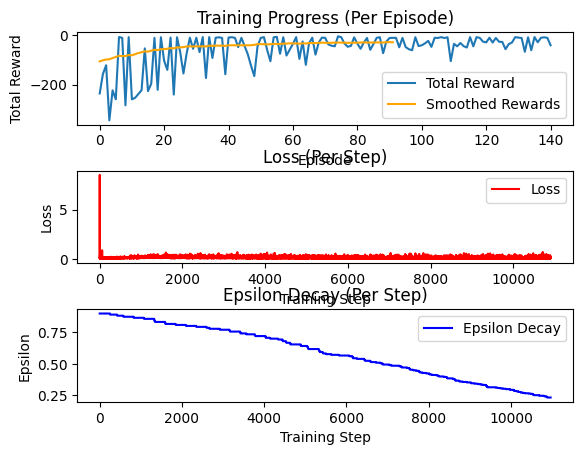

<Figure size 640x480 with 0 Axes>

Episode 141/300, Total Reward: -40.13937619680725
Loss: 0.15217854105607329
Loss: 0.0317649519822847
Loss: 0.10080732054080448
Loss: 0.13909850505597102
Loss: 0.2565575865209918
Loss: 0.12549563389365273
Loss: 0.10622265598000279
Loss: 0.11642188326808986
Loss: 0.2047288088716445
Loss: 0.5894321070105153
Loss: 0.2548958157967004
Loss: 0.05114033030317286
Loss: 0.17608257858351614
Loss: 0.18001980243649543
Loss: 0.2344174378666417
Loss: 0.09272378394784342
Loss: 0.3279695259060324
Loss: 0.07743145248877076
Loss: 0.24444950993108877
Loss: 0.09882461513739495
Loss: 0.15462614420239848
Loss: 0.03638027481911996
Loss: 0.09519749571519931
Loss: 0.046165570156034653
Loss: 0.1527753556388447
Loss: 0.035087393696011104
Loss: 0.08313971393491545
Loss: 0.15001642596454196
Loss: 0.2717927202407782
Loss: 0.14793445012387457
Loss: 0.08986346729514905
Loss: 0.12989105372089854
Loss: 0.079040094232778
Loss: 0.06457159115576316
Loss: 0.0765139004174553
Loss: 0.09814258420840014
Loss: 0.2367192462728525

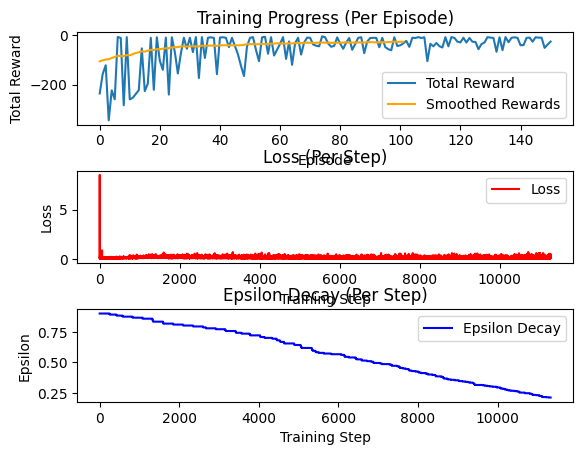

<Figure size 640x480 with 0 Axes>

Episode 151/300, Total Reward: -25.032792715073192
Loss: 0.06256458528975103
Loss: 0.07913353080201586
Loss: 0.21838046787660165
Loss: 0.11798897231848476
Loss: 0.29636016206378213
Loss: 0.07443184101026423
Loss: 0.06444761123806328
Loss: 0.28868836869811715
Loss: 0.4179053589611569
Loss: 0.24087312539988892
Loss: 0.05931156970071442
Loss: 0.05069152707478578
Done: True, Truncated: False
{'speed': 5.528651851851853, 'crashed': True, 'action': array([ 0.44, -0.5 ]), 'is_success': False}
Episode 152/300, Total Reward: -9.445674724492314
Loss: 0.11088261622513085
Loss: 0.11565787966279996
Loss: 0.20493626604342738
Loss: 0.4516179876796734
Loss: 0.17154869555289934
Loss: 0.07175592864792416
Loss: 0.07499927720497102
Loss: 0.09255742248042503
Loss: 0.14791143687269873
Loss: 0.06910902419147623
Loss: 0.3333427772818453
Loss: 0.13847457597240814
Done: True, Truncated: False
{'speed': 5.830637037037039, 'crashed': True, 'action': array([0.76, 0.5 ]), 'is_success': False}
Episode 153/300, Total

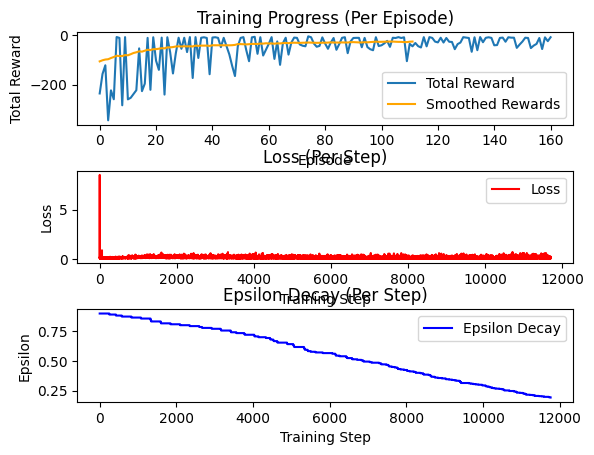

<Figure size 640x480 with 0 Axes>

Episode 161/300, Total Reward: -7.4144442509559205
Loss: 0.14357676573506814
Loss: 0.1259486355607339
Loss: 0.12230173465119255
Loss: 0.06105407731037483
Loss: 0.060002137456987084
Loss: 0.06831188318493775
Loss: 0.19722810092502985
Loss: 0.03654854948973791
Loss: 0.06808899905013206
Loss: 0.035084640059563764
Loss: 0.13975843953227887
Loss: 0.11193832411032033
Done: True, Truncated: False
{'speed': 5.880000000000001, 'crashed': True, 'action': array([ 0.56      , -0.16666667]), 'is_success': False}
Episode 162/300, Total Reward: -9.61742947573022
Loss: 0.036124571769570735
Loss: 0.05645867067694799
Loss: 0.027704701460765965
Loss: 0.386937600885158
Loss: 0.03798265359055768
Loss: 0.0965533601526124
Loss: 0.05379742299326298
Loss: 0.05648780968691497
Loss: 0.044899997807285257
Loss: 0.16694445698612942
Loss: 0.1146537356011739
Loss: 0.10817217698123825
Loss: 0.24435239366927447
Loss: 0.03860161663370941
Loss: 0.12159273480863007
Loss: 0.047799374222157125
Loss: 0.17505449149859734
Loss

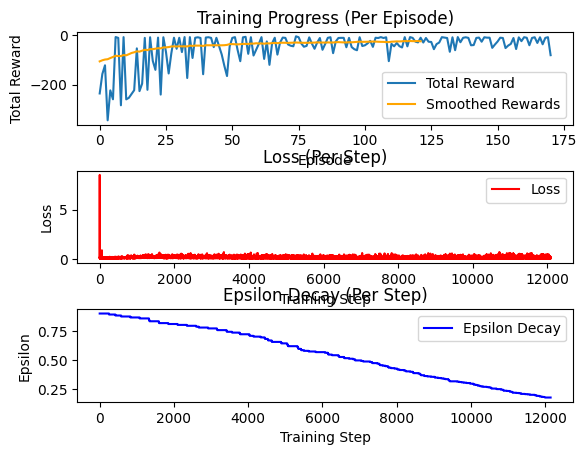

<Figure size 640x480 with 0 Axes>

Episode 171/300, Total Reward: -80.26016783203218
Loss: 0.03800195591275989
Loss: 0.1870465521270004
Loss: 0.04884439276689322
Loss: 0.13260154084739048
Loss: 0.03853129535976289
Loss: 0.41596674603852524
Loss: 0.2906526463869133
Loss: 0.044053893433717045
Loss: 0.05823820833560213
Loss: 0.03217399004637088
Loss: 0.17356529715752872
Done: True, Truncated: False
{'speed': 5.923555555555554, 'crashed': True, 'action': array([0.6       , 0.16666667]), 'is_success': False}
Episode 172/300, Total Reward: -9.693218392267507
Loss: 0.09400076115310693
Loss: 0.12952966575997502
Loss: 0.06833291479937506
Loss: 0.19986585652200403
Loss: 0.18506187532818422
Loss: 0.04194581009044794
Done: True, Truncated: False
{'speed': 2.48888888888889, 'crashed': True, 'action': array([0.4, 0.5]), 'is_success': False}
Episode 173/300, Total Reward: -7.286917154534125
Loss: 0.06454055249182253
Loss: 0.05640331017632532
Loss: 0.15262213332573996
Loss: 0.11207344055878883
Loss: 0.07669404482216162
Loss: 0.20044435

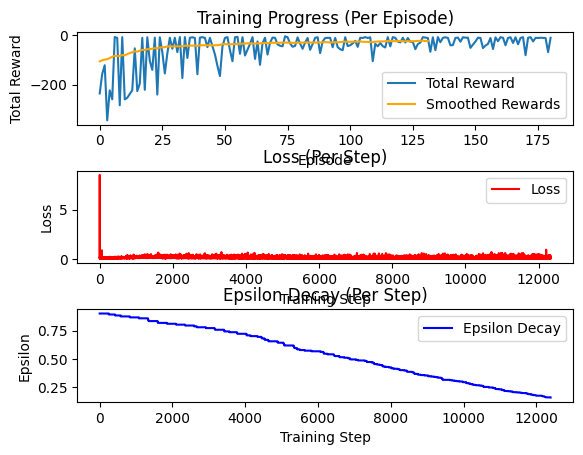

<Figure size 640x480 with 0 Axes>

Episode 181/300, Total Reward: -9.72312045327881
Loss: 0.13364722167629728
Loss: 0.12208059115189178
Loss: 0.17279787219463832
Loss: 0.08182909192010304
Loss: 0.07236251309130345
Loss: 0.041080475850540935
Loss: 0.09338307946808719
Loss: 0.049166638791368955
Loss: 0.04197608902305927
Loss: 0.24892631375656427
Loss: 0.22084925770530628
Done: True, Truncated: False
{'speed': 5.9600000000000035, 'crashed': True, 'action': array([ 0.4, -0.5]), 'is_success': False}
Episode 182/300, Total Reward: -10.060862795530847
Loss: 0.1518037355400912
Loss: 0.050851064549780375
Loss: 0.12543069161522943
Loss: 0.06311448835638596
Loss: 0.5279980254691848
Loss: 0.056009882044390676
Loss: 0.07900081231502312
Loss: 0.23832325745969238
Loss: 0.25665976590863626
Loss: 0.0447599421383631
Loss: 0.1757143628503524
Loss: 0.04456480789950173
Loss: 0.05929569337011578
Loss: 0.15591446906527393
Loss: 0.26515206066448793
Loss: 0.09024691792466258
Loss: 0.2781834203471102
Loss: 0.30491286764288783
Loss: 0.32216120733

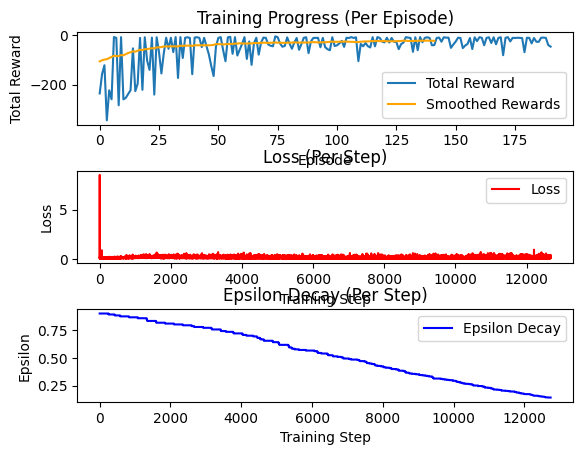

<Figure size 640x480 with 0 Axes>

Episode 191/300, Total Reward: -45.587802361524886
Loss: 0.11128705765606528
Loss: 0.1581657247141289
Loss: 0.26869231354924816
Loss: 0.10552203991070278
Loss: 0.09532167545109783
Loss: 0.19371990304863745
Loss: 0.25641339423425735
Loss: 0.16702802316907894
Loss: 0.32535904217837236
Loss: 0.1822847743507374
Done: True, Truncated: False
{'speed': 6.920000000000002, 'crashed': True, 'action': array([ 0.68      , -0.16666667]), 'is_success': False}
Episode 192/300, Total Reward: -9.142521331127124
Loss: 0.19576251826555283
Loss: 0.07417288563480065
Loss: 0.29949703033721137
Loss: 0.22900574684620412
Loss: 0.43266207919578314
Loss: 0.3264952136251541
Loss: 0.09431536106080404
Loss: 0.09795419367411817
Loss: 0.11927542426332392
Loss: 0.18394314270767947
Loss: 0.11082278467435683
Loss: 0.29119045991980447
Loss: 0.09998631491235699
Loss: 0.19624864808011416
Loss: 0.09493166552940746
Loss: 0.1783468688631544
Loss: 0.17064191598783515
Loss: 0.1420286953158925
Loss: 0.09413687724338271
Loss: 0.1

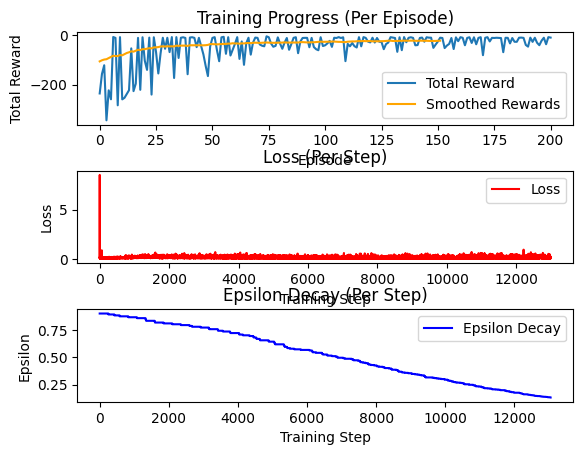

<Figure size 640x480 with 0 Axes>

Episode 201/300, Total Reward: -8.934696118192086
Loss: 0.03426556539843428
Loss: 0.027468288109022174
Loss: 0.1495170513508543
Loss: 0.14820712852353646
Loss: 0.30169968666037755
Loss: 0.15114739359682638
Loss: 0.06476541134769005
Loss: 0.11178175718914929
Loss: 0.22284552970844174
Loss: 0.4423287596682173
Loss: 0.06304675336405026
Loss: 0.030871226415032052
Done: True, Truncated: False
{'speed': 6.035555555555552, 'crashed': True, 'action': array([ 0.52      , -0.16666667]), 'is_success': False}
Episode 202/300, Total Reward: -10.569003485274603
Loss: 0.0403208449839422
Loss: 0.16738319918776945
Loss: 0.07681724343030154
Loss: 0.08723906154380233
Loss: 0.26564814556421124
Done: True, Truncated: False
{'speed': 3.0000000000000004, 'crashed': True, 'action': array([0.6, 0.5]), 'is_success': False}
Episode 203/300, Total Reward: -6.760474377358101
Loss: 0.053960152931516445
Loss: 0.1294886977388153
Loss: 0.09484771332476909
Loss: 0.09497581677945084
Loss: 0.21276334191301696
Loss: 0.117

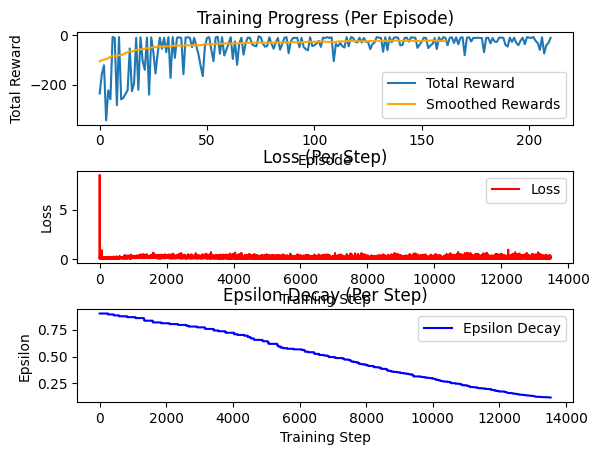

<Figure size 640x480 with 0 Axes>

Episode 211/300, Total Reward: -10.198643394267911
Loss: 0.24505284382271142
Loss: 0.06260574194232062
Loss: 0.12198049052677641
Loss: 0.23032658770104036
Loss: 0.07949288698657508
Loss: 0.022957523624603023
Loss: 0.07135495518394709
Loss: 0.06638409028029685
Loss: 0.14592870484068418
Loss: 0.052320411677247346
Loss: 0.07158236176183116
Loss: 0.515658683178239
Loss: 0.25681777188235905
Loss: 0.07803040015843102
Loss: 0.2419406341846601
Loss: 0.13535848828239594
Loss: 0.07591107055383513
Loss: 0.037641955490599434
Loss: 0.07178312577078425
Loss: 0.39103252286502377
Loss: 0.06806363437253138
Loss: 0.12125107013306272
Loss: 0.15822728841054867
Loss: 0.07898680525543046
Loss: 0.2900027141160927
Loss: 0.09475982774288744
Loss: 0.10825993292638142
Loss: 0.04675993591364504
Loss: 0.35438855840735134
Loss: 0.14490998634353894
Loss: 0.08178983669127485
Loss: 0.120948476689469
Loss: 0.0667611780418926
Loss: 0.055298958736823285
Loss: 0.0937578314501595
Loss: 0.13673884671088246
Loss: 0.218947970

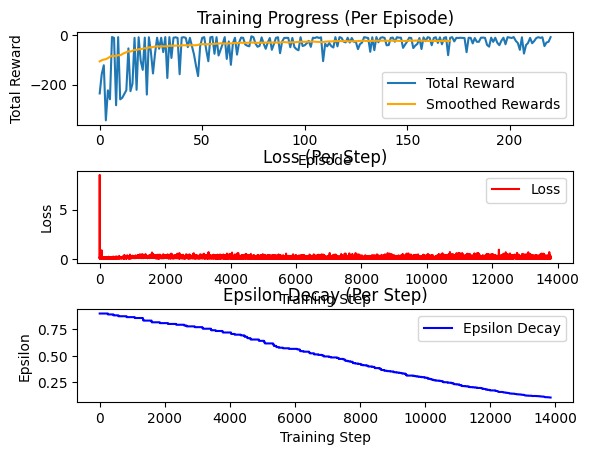

<Figure size 640x480 with 0 Axes>

Episode 221/300, Total Reward: -7.036447203533461
Loss: 0.14624919718416357
Loss: 0.0685319230223623
Loss: 0.13665932829032376
Loss: 0.15622715424268316
Loss: 0.16349680564747002
Loss: 0.23506124238020226
Loss: 0.14806452202622686
Loss: 0.13914943211413536
Loss: 0.08221858618158519
Loss: 0.2230010274999506
Loss: 0.05855665380052446
Loss: 0.1387686004808616
Loss: 0.06770223373957115
Loss: 0.38256776273268744
Loss: 0.15161138666916507
Loss: 0.342351244581632
Loss: 0.10547704083304685
Loss: 0.0783236219141625
Loss: 0.061816855182563885
Loss: 0.15715150137014539
Loss: 0.050616549232802815
Loss: 0.05294025326628969
Loss: 0.16606353277290747
Loss: 0.14826648396892908
Loss: 0.057046011975459616
Loss: 0.07553252140524405
Loss: 0.08110621960831284
Loss: 0.1583914072815609
Loss: 0.07996649710114992
Loss: 0.06530583152454285
Loss: 0.15641688088279374
Loss: 0.050288142758778326
Loss: 0.6655561386960588
Loss: 0.05114784011836963
Loss: 0.15663998084112213
Loss: 0.12551605840747132
Loss: 0.0551276222

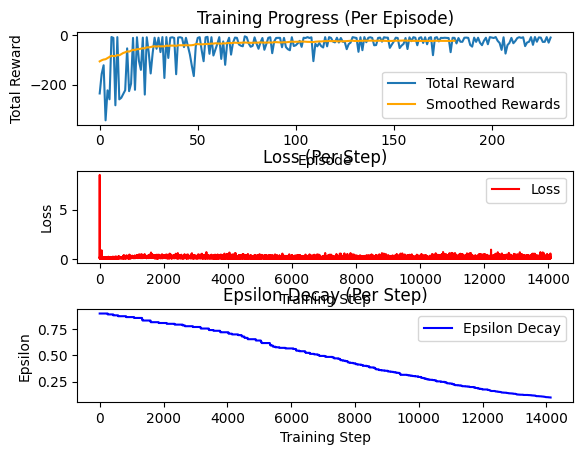

<Figure size 640x480 with 0 Axes>

Episode 231/300, Total Reward: -8.718593399817168
Loss: 0.06479479627495813
Loss: 0.13856740375721094
Loss: 0.23484386376629598
Loss: 0.13448739245068866
Loss: 0.16332594056551591
Loss: 0.16133541306633928
Loss: 0.05634706582016383
Loss: 0.17407450160390997
Loss: 0.15019243367951057
Loss: 0.0547346807321715
Loss: 0.08870504563834643
Loss: 0.028478980824920237
Loss: 0.25116714370729715
Loss: 0.14871519203963068
Loss: 0.3419555818311448
Loss: 0.16924285917990964
Loss: 0.1459418697330213
Loss: 0.06168491184638124
Loss: 0.08675199089142378
Loss: 0.0759723393834489
Loss: 0.08738884267106722
Loss: 0.06240950737945697
Loss: 0.16288363072091286
Loss: 0.13592009199912888
Loss: 0.204091424742963
Loss: 0.17352575907629597
Loss: 0.23880202077745424
Loss: 0.1765306608751471
Loss: 0.13863537623854494
Loss: 0.13992010513901193
Loss: 0.05266042964894947
Loss: 0.03519819214896255
Loss: 0.5154086991013735
Loss: 0.1444938115633755
Loss: 0.10003538950001518
Loss: 0.06364982877264434
Loss: 0.13292484215763

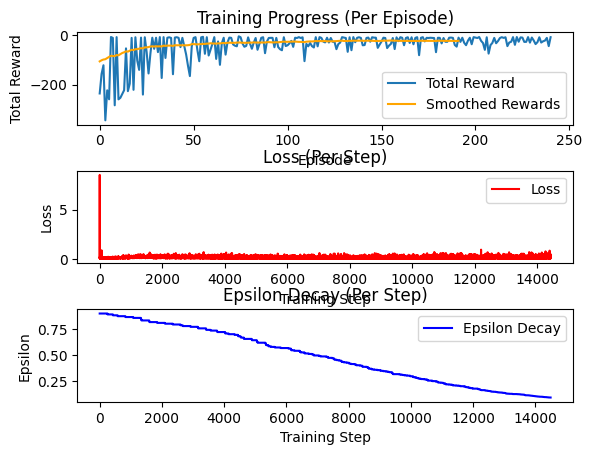

<Figure size 640x480 with 0 Axes>

Episode 241/300, Total Reward: -7.263418560049336
Loss: 0.07410348677894499
Loss: 0.18484977446952977
Loss: 0.22045815003157224
Loss: 0.2526851302606536
Loss: 0.29302987359089044
Loss: 0.30540639112872614
Loss: 0.31215049933455
Loss: 0.06281723805674747
Loss: 0.20065500142118378
Loss: 0.04831870025523474
Loss: 0.29153294864389656
Loss: 0.05119038212759963
Loss: 0.19804955028939566
Loss: 0.28628689068565066
Loss: 0.5436856231859367
Loss: 0.08969262299926123
Loss: 0.06639322137334489
Loss: 0.1578065280642182
Loss: 0.26165812757221973
Loss: 0.32839456909935066
Loss: 0.10142727520818423
Loss: 0.3775419738727762
Loss: 0.3589171559557731
Loss: 0.06332534394316625
Loss: 0.16700778264772323
Loss: 0.19163910497691708
Loss: 0.29810844122071456
Loss: 0.0891182891780658
Loss: 0.2725282842761722
Loss: 0.2142444397666584
Loss: 0.17104422506671813
Loss: 0.05912432027698665
Loss: 0.30151508598019433
Loss: 0.07924850969851956
Loss: 0.5293451682872522
Loss: 0.0497178491683225
Loss: 0.058593238783648846


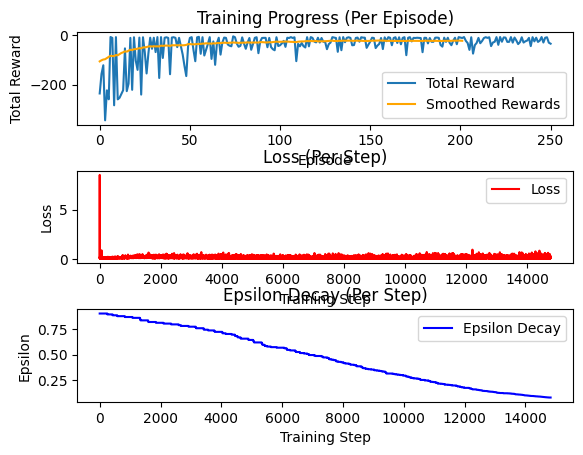

<Figure size 640x480 with 0 Axes>

Episode 251/300, Total Reward: -33.62279734912234
Loss: 0.2933085287044071
Loss: 0.16615867706744777
Loss: 0.11029372413222652
Loss: 0.4327311602839205
Loss: 0.11473697224030942
Loss: 0.28410569819319687
Loss: 0.050606833315167715
Loss: 0.07951458125217956
Loss: 0.1288669281823489
Loss: 0.16986576254339045
Done: True, Truncated: False
{'speed': 6.533333333333337, 'crashed': True, 'action': array([0.72      , 0.16666667]), 'is_success': False}
Episode 252/300, Total Reward: -9.121266408515286
Loss: 0.065106984259267
Loss: 0.6260019715115491
Loss: 0.37053846583783195
Loss: 0.1886985400548643
Loss: 0.06931960043272106
Loss: 0.1802427736996234
Done: True, Truncated: False
{'speed': 2.6133333333333346, 'crashed': True, 'action': array([ 0.72      , -0.16666667]), 'is_success': False}
Episode 253/300, Total Reward: -7.876106246643841
Loss: 0.046525309933797596
Loss: 0.16202906388302685
Loss: 0.1334108726825515
Loss: 0.277361186521548
Loss: 0.3324135528085931
Loss: 0.1573798085003657
Loss: 0.

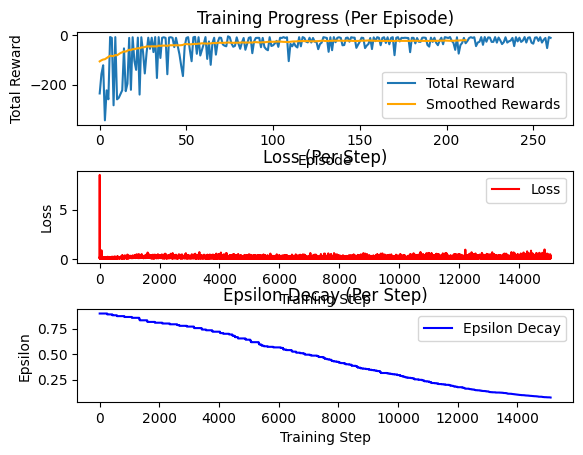

<Figure size 640x480 with 0 Axes>

Episode 261/300, Total Reward: -10.081089601085896
Loss: 0.06800376988348535
Loss: 0.24006792222983853
Loss: 0.05727536178433342
Loss: 0.07499573629969704
Loss: 0.350248608198462
Loss: 0.5662922603772225
Loss: 0.24093211517899626
Loss: 0.0511306541133832
Loss: 0.15714172656035694
Loss: 0.034835655461320426
Loss: 0.043964932068372306
Loss: 0.04168233918278631
Loss: 0.05678669153850871
Loss: 0.1277820412122471
Loss: 0.1626718984168077
Loss: 0.14450175912178032
Loss: 0.29547345287760163
Loss: 0.4884199470296452
Loss: 0.22421206824754805
Loss: 0.042280862037965154
Loss: 0.16548082668947653
Loss: 0.32521688606019084
Loss: 0.03827996034706718
Loss: 0.16176264888289063
Loss: 0.14978680054215973
Loss: 0.15895295809902554
Loss: 0.14352301667858477
Loss: 0.1496623153602933
Loss: 0.14940077361670434
Loss: 0.268351881591653
Loss: 0.27915128538874595
Loss: 0.24982833448528582
Loss: 0.033431873579017175
Loss: 0.04066794893796086
Loss: 0.1623566042671386
Loss: 0.16099560677084693
Loss: 0.054713478499

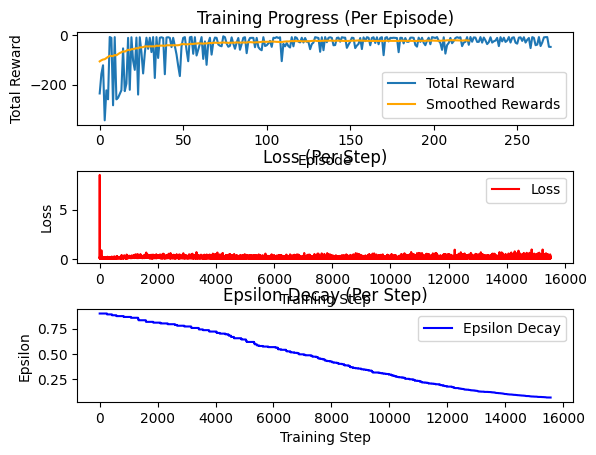

<Figure size 640x480 with 0 Axes>

Episode 271/300, Total Reward: -46.68436236422206
Loss: 0.243641641514879
Loss: 0.30205850098837717
Loss: 0.1878097292943266
Loss: 0.31682209862529237
Loss: 0.3412880005522077
Loss: 0.15761615012637606
Loss: 0.2542789702690498
Loss: 0.26142060027350256
Loss: 0.5409547748994296
Loss: 0.22739139082170975
Loss: 0.12484461148915993
Loss: 0.13222805646854816
Loss: 0.06925103690909004
Loss: 0.1464098123056266
Loss: 0.22567109433737648
Loss: 0.06336346220377166
Loss: 0.12663162387839821
Loss: 0.1904582500903174
Loss: 0.05687496755459036
Loss: 0.13135303018250635
Loss: 0.22440129704869483
Loss: 0.45231360494027906
Loss: 0.41691127698547437
Loss: 0.305535172516871
Loss: 0.23086889511316172
Loss: 0.05846177484475785
Loss: 0.14625160385702424
Loss: 0.13707714231443227
Loss: 0.36563781840565907
Loss: 0.4346765283558519
Loss: 0.12425916114267199
Loss: 0.22713588230324538
Loss: 0.16835519244206756
Loss: 0.36994031743341904
Loss: 0.043482253356917536
Loss: 0.05413688723781147
Loss: 0.3265592623065538

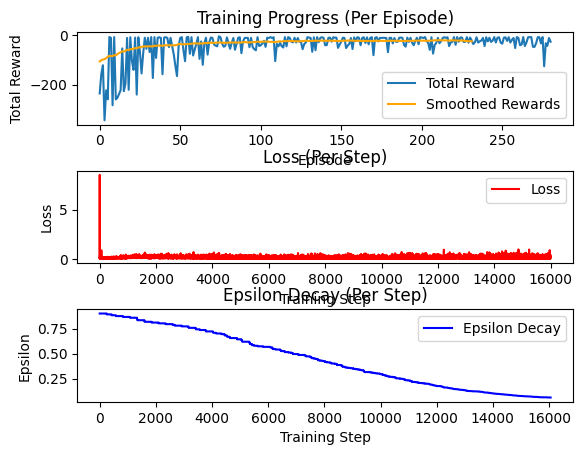

<Figure size 640x480 with 0 Axes>

Episode 281/300, Total Reward: -25.57210357246814
Loss: 0.3284294224082608
Loss: 0.03440208612347735
Loss: 0.26279172377148985
Loss: 0.049040259676912584
Loss: 0.03560227250677435
Loss: 0.19590428279089217
Loss: 0.3627800421801708
Loss: 0.17018643340841566
Loss: 0.15637277445090625
Loss: 0.1626201947662425
Loss: 0.059090544888971495
Loss: 0.13538374826726982
Loss: 0.1765414366818857
Loss: 0.11040272732339174
Loss: 0.2217923849387125
Loss: 0.040842652293089775
Loss: 0.28381435634165914
Loss: 0.19031772269210476
Loss: 0.15219559526276408
Loss: 0.06717183872482108
Loss: 0.15284165116647047
Loss: 0.052715318701460206
Loss: 0.15532574310273595
Loss: 0.2618910533943951
Loss: 0.16684423349505167
Loss: 0.14243361757383277
Loss: 0.2797084796874725
Loss: 0.05659115668891461
Loss: 0.2286352306874411
Loss: 0.08967746998600806
Loss: 0.12493540409877646
Loss: 0.13076203710843606
Loss: 0.08451365178997176
Loss: 0.261861010289521
Loss: 0.08370347548546102
Loss: 0.24598927398755804
Loss: 0.129599805643

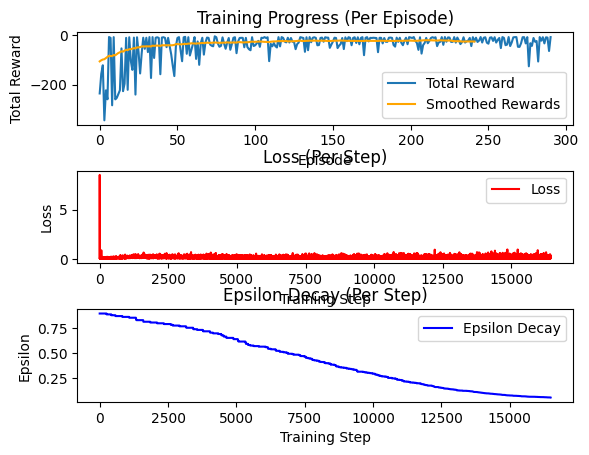

<Figure size 640x480 with 0 Axes>

Episode 291/300, Total Reward: -6.913086181352337
Loss: 0.08968935206772123
Loss: 0.15022461775995744
Loss: 0.15580791341140982
Loss: 0.18163415296009805
Loss: 0.03192954002081433
Loss: 0.16935897660520452
Loss: 0.08283225567841364
Loss: 0.09794315647029375
Loss: 0.4540026362563813
Loss: 0.1963409706319691
Loss: 0.09440228486062156
Loss: 0.2719307309946055
Loss: 0.07705264786921007
Loss: 0.18494324380123048
Loss: 0.05406364352247804
Loss: 0.18724530481669693
Loss: 0.14600254293999965
Loss: 0.14822783476995538
Loss: 0.3479438650271729
Loss: 0.15604084199379742
Loss: 0.261121060191695
Loss: 0.09271718828729075
Loss: 0.05698369918213373
Loss: 0.17659044096051574
Loss: 0.20007716066259112
Loss: 0.2598169487895142
Loss: 0.15408184513767997
Loss: 0.07203009830182444
Loss: 0.10989414741087002
Loss: 0.27925935580767036
Loss: 0.10059634330182471
Loss: 0.24526930443104344
Loss: 0.0808100114587766
Loss: 0.27176345427943255
Loss: 0.1818851124983902
Loss: 0.3253568084185382
Loss: 0.0839630771566005

<Figure size 640x480 with 0 Axes>

In [5]:
def update_target_network(t):
    if t % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

for i_episode in range(num_episodes):
    # Initialize the environment and get the initial state
    observation, info = env.reset()
    observation_vector = process_observation(observation)
    observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0  # Track the total reward for this episode
    t = 0  # Add a time step counter for the current episode
    while(True):
        # Select an action
        action_index = select_action(observation_tensor, i_episode)
        action = candidate_actions[action_index.item()]

        # Perform the action and observe the result
        observation, reward, done, truncated, info = env.step(action.numpy())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()

        # Process the next state
        if (not done) and (not truncated): # not done or not truncated
            observation_vector = process_observation(observation)
            next_observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
        else: # done or truncated
            next_observation_tensor = None

        # Store the experience in memory, including if the episode was truncated
        memory.push(observation_tensor, action_index, next_observation_tensor, reward)

        # Update the current state
        observation_tensor = next_observation_tensor

        # Optimize the policy network
        optimize_policy_net()

        # Update the target network
        update_target_network(t)

        # If the episode is done, record the result and break the loop
        if done or truncated:
            print(f"Done: {done}, Truncated: {truncated}")
            print(info)
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)

            if truncated:
                print(f"Episode {i_episode + 1} truncated after {t + 1} steps")
            elif terminated:
                print(f"Episode {i_episode + 1} finished after {t + 1} steps")

            if i_episode % 10 == 0:
                plot_training_durations()
            break

        t = t + 1

    print(f"Episode {i_episode + 1}/{num_episodes}, Total Reward: {episode_rewards[i_episode]}")

print('Training is finished')
plt.ioff()
plt.show()

In [6]:
env.close()

In [7]:
torch.save(policy_net.state_dict(), 'policy_net.pth')
torch.save(target_net.state_dict(), 'target_net.pth')

In [8]:
# sam

## test